In [1]:
import numpy as np
import cv2
import imageio
import matplotlib.pyplot as plt
from math import sqrt
from mpl_toolkits.mplot3d import Axes3D

eps = np.finfo(float).eps

# 频率域滤波器

本文主要是动手实现一些常见的滤波器，并展示其频率域和空间域图像。

这里介绍的常见滤波器为：（高通/低通）理想滤波、布特沃斯滤波器和高斯滤波器，根据书本P169页，他们的区别与联系如下：

> 这三种滤波器涵盖了从非常急剧（理想）的滤波到非常平滑（高斯）的滤波范围。布特沃斯滤波器有一个参数，它成为滤波器的“阶数”。当阶数较高时，布特沃斯滤波器接近于理想滤波器。对于较低的阶数值，布特沃斯滤波器更像高斯滤波器。这样，布特沃斯滤波器可视为两种“极端”滤波器的过渡。

为了方便后续实验，对可视化代码模块化编写。

## 一些辅助代码

### 绘制三维透视图


In [2]:
def drawPerspective(handleax,input_matrix,title=None,cmap = "gray"):
    handleax.set_title(title)
    handleax.set_zlabel('Z')  # 坐标轴
    handleax.set_ylabel('Y')
    handleax.set_xlabel('X')
    x,y = input_matrix.shape
    X = np.arange(0,x,1)
    Y = np.arange(0,y,1)
    # 由于图像x,y坐标和 meshigrid出来是互反的
    # 这里需要调转一下
    # 否则会出现mismatch的现象
    X,Y = np.meshgrid(Y, X)
    handleax.plot_surface(Y, X, input_matrix, cmap=cmap)
#     handleax.plot_wireframe(Y, X, input_matrix, cmap=cmap)
    

### 绘制平面图

In [3]:
def drawPanel(handleax,input_matrix,title=None,cmap = "gray"):
    handleax.set_title(title)
    handleax.set_ylabel('Y')
    handleax.set_xlabel('X')
    handleax.imshow(input_matrix,cmap = cmap)

### 绘制曲线图

In [4]:
def drawCurv(handleax,functions,labels,filter_d0,title=None,cmap = "gray"):
    # 绘制从0到 3D_0的函数剖面图
    handleax.set_title(title)
    handleax.set_xlabel("$D(u,v)$")
    handleax.set_ylabel("$H(u,v)$")
    # 标出D_0点
    # handleax.annotate(r"$D_0$", xy = (filter_d0,0) , weight='heavy')
    
    for func,lab in zip(functions,labels):
        # 对每一对func和label绘图 （针对需要画多条线的情况）
        X = np.arange(0,3*filter_d0+1,0.1)
        Y = func(X)
        handleax.plot(X,Y,label = lab)
    handleax.set_xticks([0,filter_d0])
    handleax.set_xticklabels(["$0$","$D_0$"])
    handleax.legend()

### 频率域转空间域

In [5]:
def frequencyToSpatial(input_matrix):
    # 这里不太明白为什么shift与否最后都需要添加一个fftshift来得到想要的空间域图像
    shift_input_matrix = np.fft.ifftshift(input_matrix)
#     shift_input_matrix = input_matrix
    spatial_img = np.abs(np.fft.ifft2(shift_input_matrix))
    spatial_img = np.fft.fftshift(spatial_img)
    return spatial_img

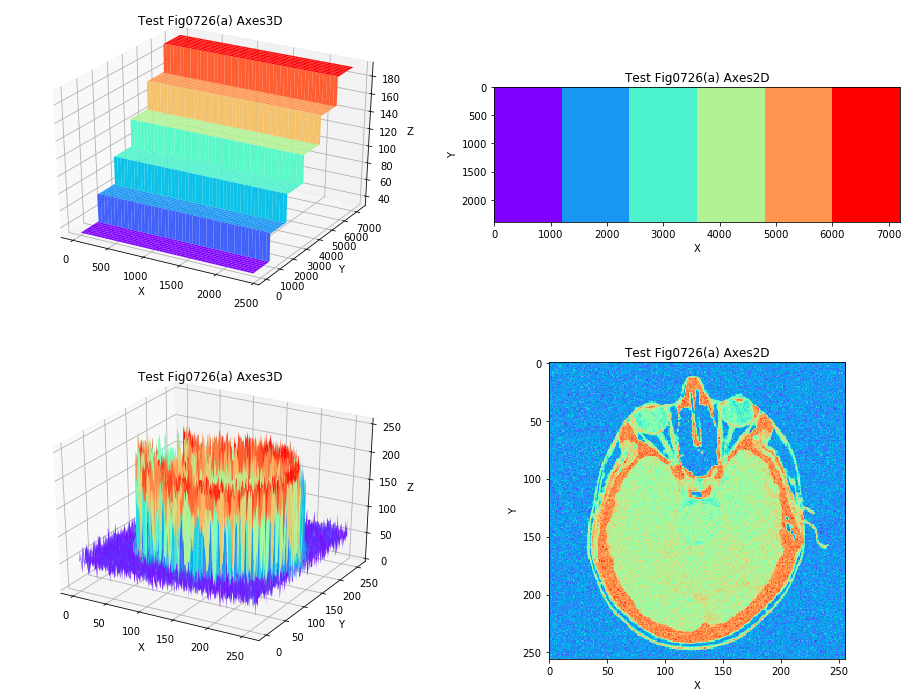

In [6]:
# 测试1

# 替换为自己的图片地址
# test_img1 = cv2.imread('./DIP3E_Original_Images_CH02/Fig0207(a)(gray level band).tif',0)
# test_img2 = cv2.imread('./DIP3E_CH07_Original_Images/Fig0726(a).tif',0)
plt.figure(figsize=(16,12))
ax1 = plt.subplot(221,projection = "3d")
ax2 = plt.subplot(222)
ax3 = plt.subplot(223,projection = "3d")
ax4 = plt.subplot(224)
drawPerspective(ax1,test_img1,"Test Fig0726(a) Axes3D","rainbow")
drawPanel(ax2,test_img1,"Test Fig0726(a) Axes2D","rainbow")
drawPerspective(ax3,test_img2,"Test Fig0726(a) Axes3D","rainbow")
drawPanel(ax4,test_img2,"Test Fig0726(a) Axes2D","rainbow")
plt.show()

In [1]:
# 测试2
test_d0 = 10
test_funcs1 = []
test_funcs1.append(lambda x: np.sin(x))
test_funcs1.append(lambda x: np.cos(x))
test_labels1 = ["$sin(x)$","$cos(x)$"]

test_funcs2 = []
test_funcs2.append(lambda x: np.sqrt(x))
test_funcs2.append(lambda x: np.exp(-(x**2)/(2*(test_d0)**2)))
test_labels2 = ["$x$","$e^{\dfrac{-D^2(u,v)}{2 D_0^2}}$"]

plt.figure(figsize=(14,7))
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)
drawCurv(ax1,test_funcs1,test_labels1,test_d0,title="Test sin(x) and cos(x)")
drawCurv(ax2,test_funcs2,test_labels2,test_d0,title="Test x and gaussian")
plt.show()

NameError: name 'plt' is not defined

## 理想滤波器

所谓"理想"是指无法通过硬件实现硬截断

### 理想低通滤波器 ILPF

在圆外“阻断”所有频率，而在圆内无衰减的通过所有频率，这种二维低通滤波器称为理想低通滤波器（ILPF），由下面的函数确定

$$
H_{ILPF}(u,v) = \left \{ 
\begin{aligned}
1, & D(u,v) \le D_0 \\
0, & D(u,b) > D_0
\end{aligned}
\right.
$$

其中$D_0$是一个正常数，$D(u,v)$表示频率域中的点$(u,v)$距离频率域中心$(\frac{P}{2},\frac{Q}{2})$的距离。

### 理想高通滤波器 IHPF

与低通类似，高通是将阈值的圆内“阻断”所有频率，而在圆外无衰减的通过所有频率，描述如下

$$
H_{IHPF}(u,v) = \left \{ 
\begin{aligned}
0, & D(u,v) \le D_0 \\
1, & D(u,b) > D_0
\end{aligned}
\right.
$$


### 代码实现
代码实现低通滤波器并展示其频率域透视图、频率域图像显示、空间域图像显示和径向剖面图。

In [2]:
# 获得指定大小的理想滤波器
def getIdealMask(mask_shape, filter_d0,hl_type):
    assert hl_type in ("lpf","hpf")
    rows,cols = mask_shape[0],mask_shape[1]
    crow = rows/2
    ccol = cols/2
    mask = np.zeros((rows,cols))
    for i in range(rows):
        for j in range(cols):
            dis = sqrt((i-crow)**2 + (j-ccol)**2)
            if hl_type == "lpf":
                if dis <= filter_d0:
                    mask[i,j] = 1
                else:
                    mask[i,j] = 0
            elif hl_type == "hpf":
                if dis <= filter_d0:
                    mask[i,j] = 0
                else:
                    mask[i,j] = 1
    return mask

# 测试ILPF
# 参数设置
mask_shape = (100,100)
d = 20
filter_type = "lpf"
# 获得滤波器
myfilter = getIdealMask(mask_shape,d,filter_type)
# 绘图
plt.figure(figsize=(12,12))
ax1=plt.subplot(221,projection = "3d")
ax2=plt.subplot(222)
ax3=plt.subplot(223)
ax4=plt.subplot(224)
drawPerspective(ax1,myfilter,title = "ILPF Perspective Axes3D", cmap = "gray")
# 不想进行列表解析,需要调用frompyfunc构建np可以用的分段函数
ufunc1 = np.frompyfunc(lambda x: 0 if (x-d)>0 else 1, 1, 1)
drawCurv(ax2,[ufunc1],["ILPF"],d,title = "ILPF Curv")
drawPanel(ax3,myfilter,title = "ILPF Frequency Panel Axes2D")
spatial_myfilter = frequencyToSpatial(myfilter)
drawPanel(ax4,spatial_myfilter,title = "ILPF Spatial Panel Axes2D")
plt.show()

# 测试IHPF
d = 20
filter_type = "hpf"
myfilter = getIdealMask(mask_shape,d,filter_type)
plt.figure(figsize=(12,12))
ax1=plt.subplot(221,projection = "3d")
ax2=plt.subplot(222)
ax3=plt.subplot(223)
ax4=plt.subplot(224)
drawPerspective(ax1,myfilter,title = "IHPF Perspective Axes3D", cmap = "gray")
# 不想进行列表解析,需要调用frompyfunc构建np可以用的分段函数
ufunc1 = np.frompyfunc(lambda x: 1 if (x-d)>0 else 0, 1, 1)
drawCurv(ax2,[ufunc1],["IHPF"],d,title = "Curv")
drawPanel(ax3,myfilter,title = "IHPF Frequency Panel Axes2D")
spatial_myfilter = frequencyToSpatial(myfilter)
drawPanel(ax4,spatial_myfilter,title = "IHPF Spatial Panel Axes2D")
plt.show()


NameError: name 'np' is not defined

## 布特沃斯滤波器

可通过硬件实现，可以通过阶数进行控制，一些资料中又称之为“巴特沃斯滤波器”。

### 布特沃斯低通滤波器 BLPF

截止频率位于距原点$D_0$的$n$阶布特沃斯滤波器（BLPF）的传递函数定义为：

$$H_{BLPF}(u,v) = \dfrac{1}{ 1 + {[ \dfrac {D(u,v)}{D_0} ]}^{2n} }$$

### 布特沃斯高通滤波器 BHPF

对应的传递函数定义为：

$$H_{BHPF}(u,v) = \dfrac{1}{ 1 + {[ \dfrac {D_0}{D_(u,v)} ]}^{2n} }$$

（分母分子颠倒）

两式中$n$对应了即阶参数，下面的代码给出巴特沃斯滤波器的实现，其频率域透视图、频率域图像显示、空间域图像显示和径向剖面图，曲线图绘制出不同阶下的取值。

In [3]:
# 获得指定大小的布特沃斯滤波器
def getButterworthMask(mask_shape,filter_d0,hl_type,butter_n = 1):
    assert hl_type in ("lpf","hpf")
    rows,cols = mask_shape[0],mask_shape[1]
    crow = rows/2
    ccol = cols/2
    mask = np.zeros((rows,cols))
    for i in range(rows):
        for j in range(cols):
            dis = sqrt((i-crow)**2 + (j-ccol)**2)
            if hl_type == "lpf":
                mask[i,j] = 1.0/(1+(dis/filter_d0)**(2*butter_n))
            elif hl_type == "hpf":
                # 除以0情况特判一下
                if np.abs(dis)<eps:
                    mask[i,j] = 0
                else:
                    mask[i,j] = 1.0/(1+(filter_d0/dis)**(2*butter_n))
                
    return mask

# 测试BLPF
# 参数设置
mask_shape = (100,100)
d = 20
filter_type = "lpf"
# 获得滤波器
myfilter = getButterworthMask(mask_shape,d,filter_type, butter_n=2)
# 绘图
plt.figure(figsize=(12,12))
ax1=plt.subplot(221,projection = "3d")
ax2=plt.subplot(222)
ax3=plt.subplot(223)
ax4=plt.subplot(224)
drawPerspective(ax1,myfilter,title = "BLPF(n=2) Perspective Axes3D", cmap = "gray")
funcs = []
labels = []
for i in range(1,6):
    labels.append("BLPF "+"n="+str(i))
funcs.append(lambda x:1.0/(1+(x/d)**(2*1)))
funcs.append(lambda x:1.0/(1+(x/d)**(2*2)))
funcs.append(lambda x:1.0/(1+(x/d)**(2*3)))
funcs.append(lambda x:1.0/(1+(x/d)**(2*4)))
funcs.append(lambda x:1.0/(1+(x/d)**(2*5)))

drawCurv(ax2,funcs,labels,d,title = "BLPF(n=1,2,3,4,5) Curv")
drawPanel(ax3,myfilter,title = "BLPF(n=2) Frequency Panel Axes2D")
spatial_myfilter = frequencyToSpatial(myfilter)
drawPanel(ax4,spatial_myfilter,title = "BLPF(n=2) Spatial Panel Axes2D")
plt.show()

# 测试BHPF
d = 20
filter_type = "hpf"
myfilter = getButterworthMask(mask_shape,d,filter_type, butter_n=1)
plt.figure(figsize=(12,12))
ax1=plt.subplot(221,projection = "3d")
ax2=plt.subplot(222)
ax3=plt.subplot(223)
ax4=plt.subplot(224)
drawPerspective(ax1,myfilter,title = "BHPF(n=2) Perspective Axes3D", cmap = "gray")
funcs = []
labels = []
for i in range(1,6):
#     funcs.append(lambda x:1.0/(1+(d/x)**(2*i)))
#     ufunc = np.frompyfunc(lambda x: 0 if np.abs(x)<eps else 1.0/(1+(d/x)**(2*i)), 1, 1)
#     funcs.append(ufunc)
    labels.append("BHPF "+"n="+str(i))
ufunc1 = np.frompyfunc(lambda x: 0 if np.abs(x)<eps else 1.0/(1+(d/x)**(2*1)), 1, 1)
ufunc2 = np.frompyfunc(lambda x: 0 if np.abs(x)<eps else 1.0/(1+(d/x)**(2*2)), 1, 1)
ufunc3 = np.frompyfunc(lambda x: 0 if np.abs(x)<eps else 1.0/(1+(d/x)**(2*3)), 1, 1)
ufunc4 = np.frompyfunc(lambda x: 0 if np.abs(x)<eps else 1.0/(1+(d/x)**(2*4)), 1, 1)
ufunc5 = np.frompyfunc(lambda x: 0 if np.abs(x)<eps else 1.0/(1+(d/x)**(2*5)), 1, 1)
funcs.append(ufunc1)
funcs.append(ufunc2)
funcs.append(ufunc3)
funcs.append(ufunc4)
funcs.append(ufunc5)
    
    
drawCurv(ax2,funcs,labels,d,title = "BHPF(n=1,2,3,4,5) Curv")
drawPanel(ax3,myfilter,title = "BHPF(n=2) Frequency Panel Axes2D")
spatial_myfilter = frequencyToSpatial(myfilter)
drawPanel(ax4,spatial_myfilter,title = "BHPF(n=2) Spatial Panel Axes2D")
plt.show()


NameError: name 'np' is not defined

### 高斯低通滤波器 GLPF

高斯低通滤波器二维形式由下式给处：

$$H_{GLPF}(u,v) = e^{\dfrac{-D^2(u,v)}{2 \sigma^2}}$$

$\sigma$描述了中心的扩散速度，和其他滤波器描述式统一，通过令$\sigma = D_0$，可以用表示其他滤波器的方法表示高斯滤波器。

$$H_{GLPF}(u,v) = e^{\dfrac{-D^2(u,v)}{2 D_0^2}}$$

### 高斯高通滤波器 GHPF

如下：

$$H_{GHPF}(u,v) =1 - e^{\dfrac{-D^2(u,v)}{2 \sigma^2}}$$

In [4]:
# 获得指定大小的高斯滤波器
def getGaussianMask(mask_shape,filter_d0,hl_type):
    assert hl_type in ("lpf","hpf")
    rows,cols = mask_shape[0],mask_shape[1]
    crow = rows/2
    ccol = cols/2
    mask = np.zeros((rows,cols))
    for i in range(rows):
        for j in range(cols):
            dis = sqrt((i-crow)**2 + (j-ccol)**2)
            if hl_type == "hpf":  
                mask[i,j] = 1-np.exp(-(dis**2) / (2*(filter_d0**2)))
            elif hl_type == "lpf":
                mask[i,j] = np.exp(-(dis**2)/(2*(filter_d0**2)))
    return mask

# 测试GLPF
# 参数设置
mask_shape = (200,200)
d = 20
filter_type = "lpf"
# 获得滤波器
myfilter = getGaussianMask(mask_shape,d,filter_type)
# 绘图
plt.figure(figsize=(12,12))
ax1=plt.subplot(221,projection = "3d")
ax2=plt.subplot(222)
ax3=plt.subplot(223)
ax4=plt.subplot(224)
drawPerspective(ax1,myfilter,title = "GLPF Perspective Axes3D", cmap = "gray")
drawCurv(ax2,[lambda x:np.exp(-(x**2)/(2*(d**2)))],["GLPF"],d,title = "GLPF Curv")
drawPanel(ax3,myfilter,title = "GLPF Frequency Panel Axes2D")
spatial_myfilter = frequencyToSpatial(myfilter)
drawPanel(ax4,spatial_myfilter,title = "GLPF Spatial Panel Axes2D")
plt.show()

# 测试GHPF
d = 20
filter_type = "hpf"
myfilter = getGaussianMask(mask_shape,d,filter_type)
plt.figure(figsize=(12,12))
ax1=plt.subplot(221,projection = "3d")
ax2=plt.subplot(222)
ax3=plt.subplot(223)
ax4=plt.subplot(224)
drawPerspective(ax1,myfilter,title = "GLPF Perspective Axes3D", cmap = "gray")
drawCurv(ax2,[lambda x:1-np.exp(-(x**2)/(2*(d**2)))],["GHPF"],d,title = "GLPF Curv")
drawPanel(ax3,myfilter,title = "GLPF Frequency Panel Axes2D")
spatial_myfilter = frequencyToSpatial(myfilter)
drawPanel(ax4,spatial_myfilter,title = "GLPF Spatial Panel Axes2D")
plt.show()

NameError: name 'np' is not defined

## 总结

在规定滤波器为100x100，阈值为20时，可以明显观察到，理想滤波器->高阶布特沃斯滤波器->低阶布特沃斯滤波器->高斯滤波器，可以由函数Curv看出对应的过渡。

我们同时也发现理想滤波器确实会存在**振铃特性**，这个将在后面的文章中再做分析学习。